# Clustering RGB image features with PhenoGraph

#### This notebook uses the matrix of 672 features per single cell RGB cropped image to cluster the cells and identify which are red blood cells based on clustering pattern

## Importing

In [1]:
import warnings
# To ignore Pandas Future Warning
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import scanpy as sc
import pandas as pd
from matplotlib import pyplot as plt
import phenograph
import copy
from scipy import sparse
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
%matplotlib inline

In [2]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
print("phenograph==", phenograph.__version__)
sc.settings.set_figure_params(dpi=80, facecolor='white')

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.3 scipy==1.9.1 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.1 pynndescent==0.5.7
phenograph== 1.5.7


In [3]:
from os import listdir
from os.path import isfile, join

### Read in feature matrix as csv

In [4]:
pt = 'P53'

In [5]:
# read in features from each fov
feats_dir = 'Normalized_RGB_feats/'
tables = [f for f in listdir(feats_dir) if isfile(join(feats_dir, f))]
tables.sort()

In [6]:
# create all-fov feats table
all_fovs = pd.read_csv(feats_dir + tables[0], index_col=0)

for i in range(1,len(tables)):
    data = pd.read_csv(feats_dir + tables[i], index_col=0)
    all_fovs = pd.concat([all_fovs, data])
    
all_fovs

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
P53_FOV01_cell_1,0.397206,2.532707,3.138440,2.606622,0.569811,0.417932,2.337993,-0.161569,0.865878,0.380540,...,0.517318,0.015619,0.149195,-0.023602,1.781054,0.195688,3.405890,0.098195,0.582458,-0.062832
P53_FOV01_cell_2,0.382726,2.479754,3.101453,2.422769,0.704540,0.546709,2.281925,-0.157417,0.843813,0.476370,...,0.508199,0.043232,0.355212,0.023408,1.795341,0.254605,3.419880,0.071748,0.544513,-0.055616
P53_FOV01_cell_3,0.353783,2.635136,3.064972,2.404355,0.625155,0.531350,2.309843,-0.152596,0.920654,0.468477,...,0.475065,0.208576,0.458231,0.032246,1.841517,0.254031,3.379925,-0.023110,0.511981,-0.038260
P53_FOV01_cell_4,0.398656,2.399106,3.150877,2.516380,0.553916,0.451650,2.330665,-0.157819,0.763614,0.391701,...,0.507216,0.001158,0.390842,0.007100,1.749778,0.170290,3.434626,0.029311,0.584694,-0.067509
P53_FOV01_cell_5,0.411017,2.521515,3.061525,2.400245,0.646850,0.455493,2.271724,-0.146888,0.792838,0.454227,...,0.485525,0.259338,0.541917,0.062610,1.811665,0.216929,3.450253,-0.042533,0.588866,-0.045541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P53_FOV25_cell_8326,0.404782,2.662795,3.078344,2.592948,0.659426,0.371273,2.312179,-0.138838,0.853400,0.315998,...,0.502407,-0.020913,0.172138,0.016004,1.787078,0.212266,3.428827,-0.033219,0.571282,-0.038530
P53_FOV25_cell_8328,0.393677,2.643179,3.102572,2.579643,0.739829,0.436797,2.312051,-0.092094,0.907337,0.309268,...,0.490278,-0.041844,0.240535,0.007799,1.775779,0.156707,3.462409,-0.005590,0.562735,-0.008721
P53_FOV25_cell_8329,0.406400,2.504553,3.175237,2.602478,0.590136,0.430176,2.335175,-0.155714,0.859605,0.296007,...,0.502700,-0.035296,0.356231,-0.003331,1.751841,0.152177,3.425045,-0.011398,0.594276,-0.016787
P53_FOV25_cell_8330,0.389740,2.623061,3.097733,2.584670,0.819068,0.434037,2.324683,-0.144746,0.832600,0.295442,...,0.501063,-0.035158,0.269853,0.011896,1.790835,0.160552,3.432439,-0.026697,0.529494,-0.046941


In [7]:
# concatenate individual FOV feature tables as 1 large feature table
all_fovs.to_csv(pt + "_all_cell_RGB_features.csv", header=False)

In [8]:
# read in feature matrix as anndata object for clustering
adata = sc.read_csv(pt + "_all_cell_RGB_features.csv", first_column_names=True)
adata

AnnData object with n_obs × n_vars = 144976 × 672

In [9]:
adata.obs

""
P53_FOV01_cell_1
P53_FOV01_cell_2
P53_FOV01_cell_3
P53_FOV01_cell_4
P53_FOV01_cell_5
...
P53_FOV25_cell_8326
P53_FOV25_cell_8328
P53_FOV25_cell_8329
P53_FOV25_cell_8330


In [10]:
# load FOV metadata
FOV_metadata = pd.read_csv('/data/Zhaolab/1_AMLCosMx/Final_scripts/4_CellTyping/FOV_metadata.csv', index_col=0)
FOV_metadata

,Timepoint,Clinical outcome
P51_FOV01,A,PD
P51_FOV02,A,PD
P51_FOV03,A,PD
P51_FOV04,A,PD
P51_FOV05,A,PD
...,...,...
P58_FOV19,C,SD
P58_FOV20,C,SD
P58_FOV21,C,SD
P58_FOV22,C,SD


In [11]:
# get FOV and cell number from cell ID o

adata.obs['FOV'] = ''
adata.obs['cell_ID'] = 0
adata.obs['Timepoint'] = ''

for i in range(adata.obs.shape[0]):
    adata.obs['FOV'].iloc[i] = adata.obs.iloc[i].name[7:9]
    adata.obs['cell_ID'].iloc[i] = adata.obs.iloc[i].name[15:].replace('.png', '')
    adata.obs['Timepoint'].iloc[i] = FOV_metadata['Timepoint'].loc[adata.obs.iloc[i].name[0:9]]

adata.obs

/tmp/ipykernel_2398823/4186933571.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['FOV'].iloc[i] = adata.obs.iloc[i].name[7:9]
/tmp/ipykernel_2398823/4186933571.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['cell_ID'].iloc[i] = adata.obs.iloc[i].name[15:].replace('.png', '')


,FOV,cell_ID,Timepoint
P53_FOV01_cell_1,01,1,A
P53_FOV01_cell_2,01,2,A
P53_FOV01_cell_3,01,3,A
P53_FOV01_cell_4,01,4,A
P53_FOV01_cell_5,01,5,A
...,...,...,...
P53_FOV25_cell_8326,25,8326,C
P53_FOV25_cell_8328,25,8328,C
P53_FOV25_cell_8329,25,8329,C
P53_FOV25_cell_8330,25,8330,C


In [12]:
# save copy of complete anndata object
adata_all = adata

## Cluster Timepoint A FOVs for RBCs

In [13]:
tp = 'A'

In [14]:
# subset adata to just TPA
adata = adata_all[adata_all.obs['Timepoint'] == tp]
adata

View of AnnData object with n_obs × n_vars = 29360 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint'

## Pre-Processing

### Log-Transformation

In [15]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [16]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

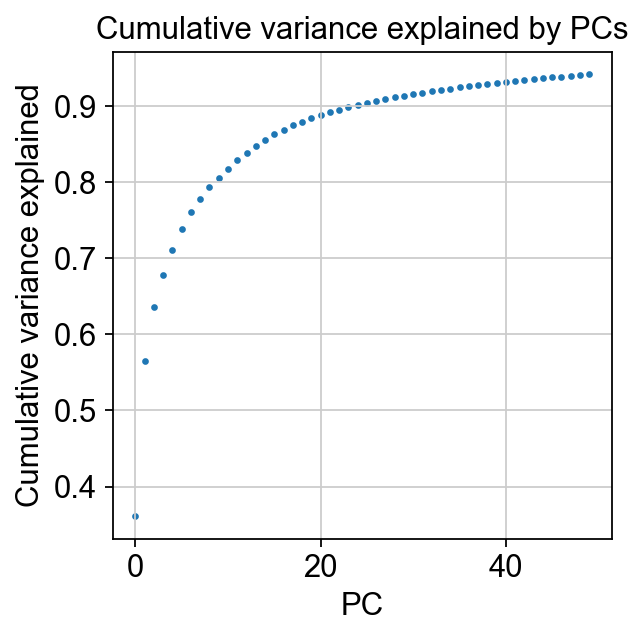

In [17]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [18]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [19]:
k = 25 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 25 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 20.980977773666382 seconds
Jaccard graph constructed in 9.442166328430176 seconds
Wrote graph to binary file in 0.27550387382507324 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.721787
After 3 runs, maximum modularity is Q = 0.724814
After 10 runs, maximum modularity is Q = 0.72616
Louvain completed 30 runs in 26.738248586654663 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 60.35138916969299 seconds


In [20]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


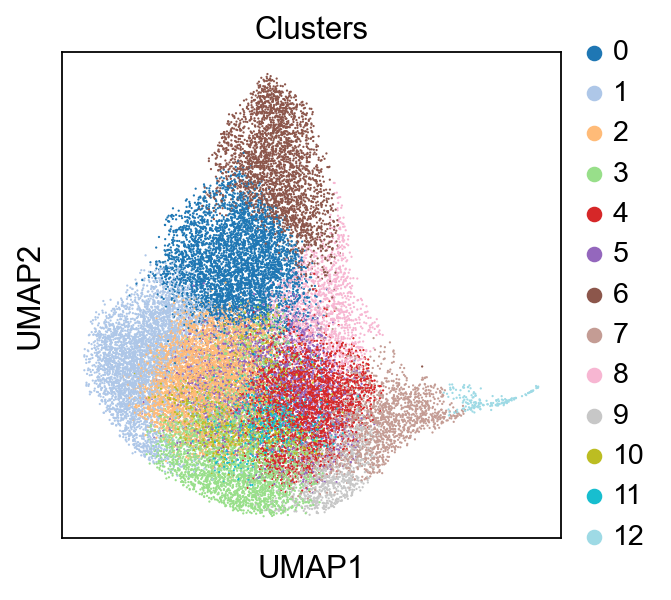

In [21]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


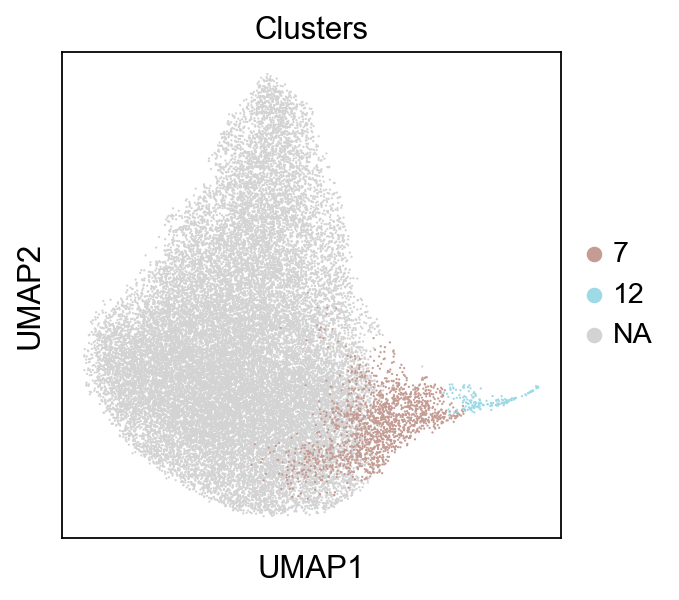

In [22]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[7,12]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


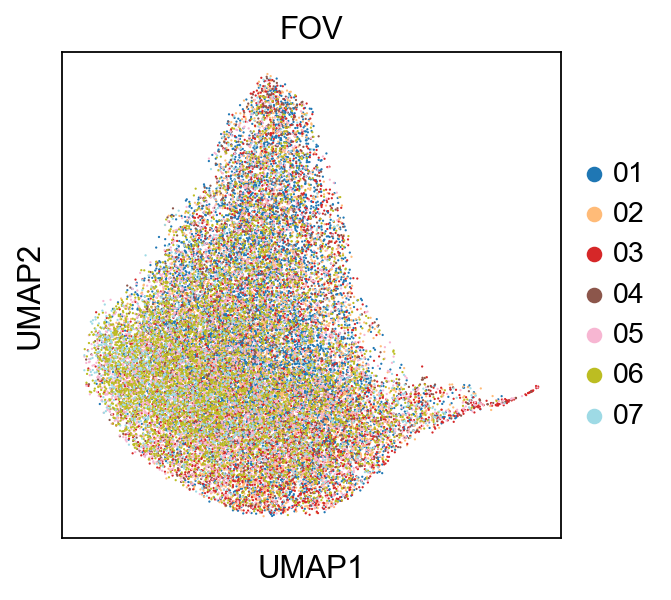

In [23]:
sc.pl.umap(
    adata, 
    color=['FOV'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["FOV"]
)

In [24]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv('TP' + tp + '/' + pt + tp + '_RGB_clusters.csv')

In [25]:
# save clustered data anndata object
adata_all.write_h5ad('TP' + tp + '/' + pt + tp + '_RGB_cell_features_clustered.h5ad')

## Cluster Timepoint B FOVs for RBCs

In [33]:
tp = 'B'

In [34]:
# subset adata to just TPA
adata = adata_all[adata_all.obs['Timepoint'] == tp]
adata

View of AnnData object with n_obs × n_vars = 85015 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint'

## Pre-Processing

### Log-Transformation

In [35]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [36]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

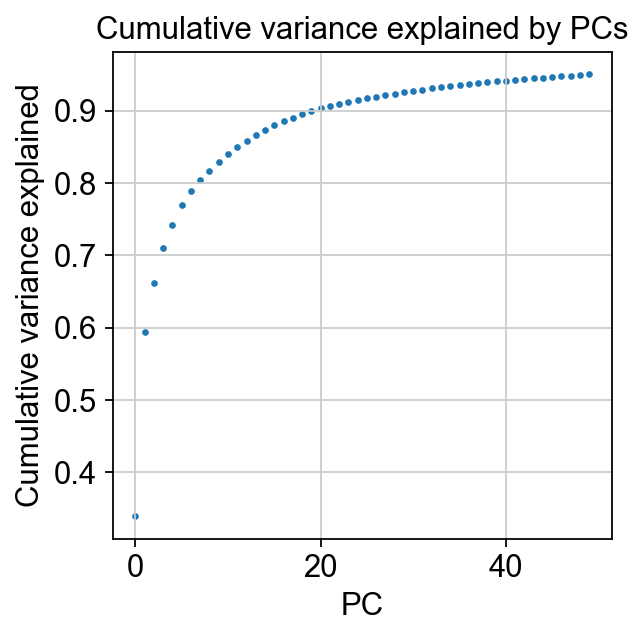

In [37]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [38]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [39]:
k = 15 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 179.18720626831055 seconds
Jaccard graph constructed in 13.417190790176392 seconds
Wrote graph to binary file in 0.4051647186279297 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.783175
After 12 runs, maximum modularity is Q = 0.784567
After 16 runs, maximum modularity is Q = 0.785933
Louvain completed 36 runs in 69.1425096988678 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 266.30888295173645 seconds


In [40]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

In [41]:
# read in clustered df
#adata = sc.read_h5ad("P56" + tp + "_RGB_cell_features_clustered.h5ad")
#adata

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


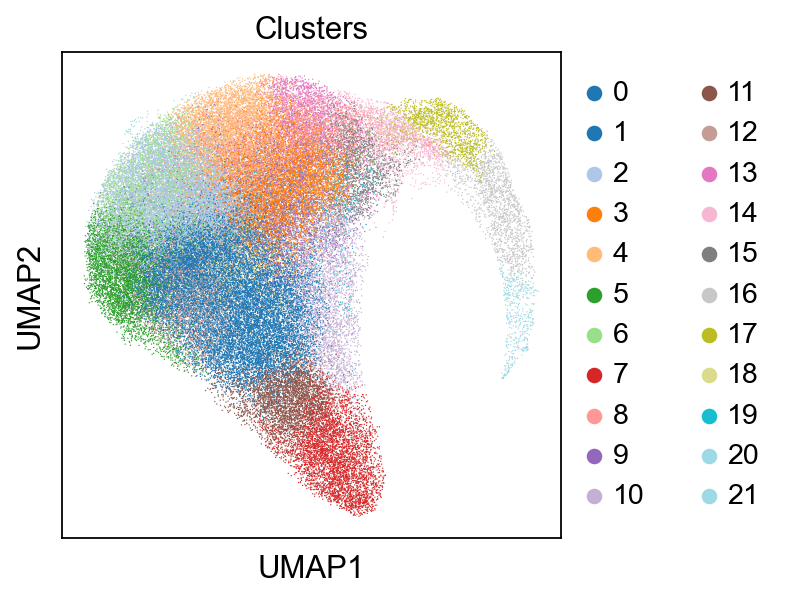

In [42]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


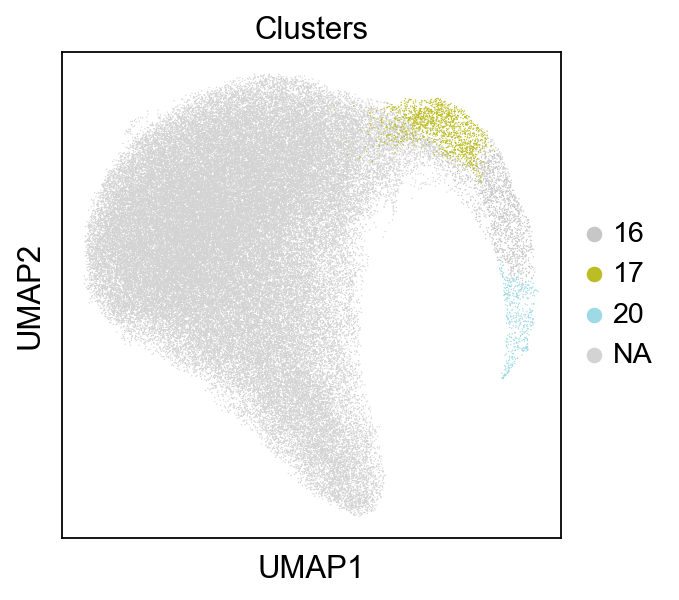

In [48]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[16,17,20]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


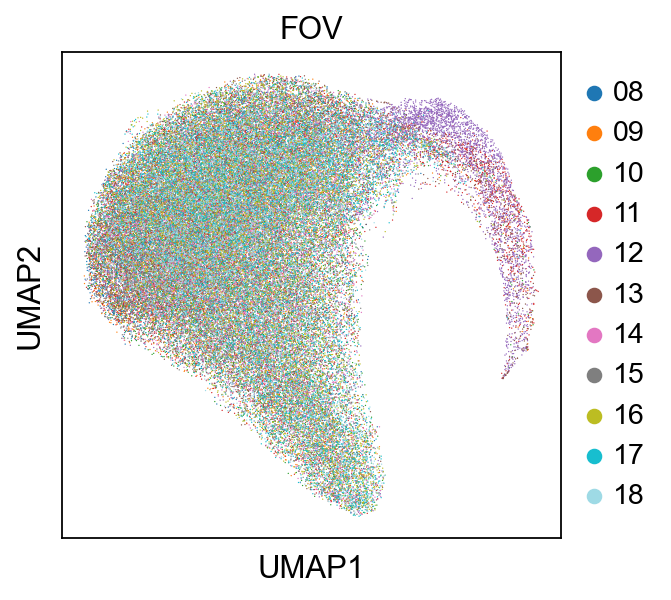

In [45]:
sc.pl.umap(
    adata, 
    color=['FOV'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["FOV"]
)

In [46]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv('TP' + tp + '/' + pt + tp + '_RGB_clusters.csv')

In [47]:
# save clustered data anndata object
adata_all.write_h5ad('TP' + tp + '/' + pt + tp + '_RGB_cell_features_clustered.h5ad')

## Cluster Timepoint C FOVs for RBCs

In [49]:
tp = 'C'

In [50]:
# subset adata to just TPA
adata = adata_all[adata_all.obs['Timepoint'] == tp]
adata

View of AnnData object with n_obs × n_vars = 30601 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint'

## Pre-Processing

### Log-Transformation

In [51]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [52]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

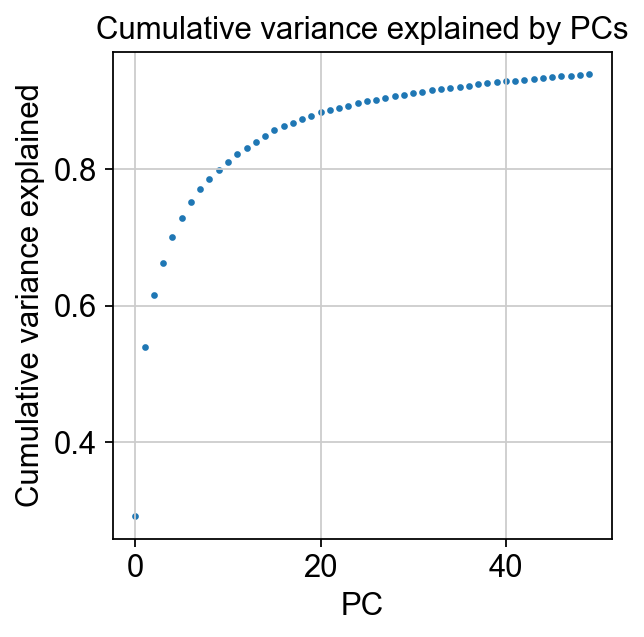

In [53]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [54]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [55]:
k = 15 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 26.004859447479248 seconds
Jaccard graph constructed in 12.90277624130249 seconds
Wrote graph to binary file in 0.2611260414123535 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.761228
Louvain completed 21 runs in 14.517299890518188 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 58.80013060569763 seconds


In [56]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

In [57]:
# read in clustered df
#adata = sc.read_h5ad("P56" + tp + "_RGB_cell_features_clustered.h5ad")
#adata

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


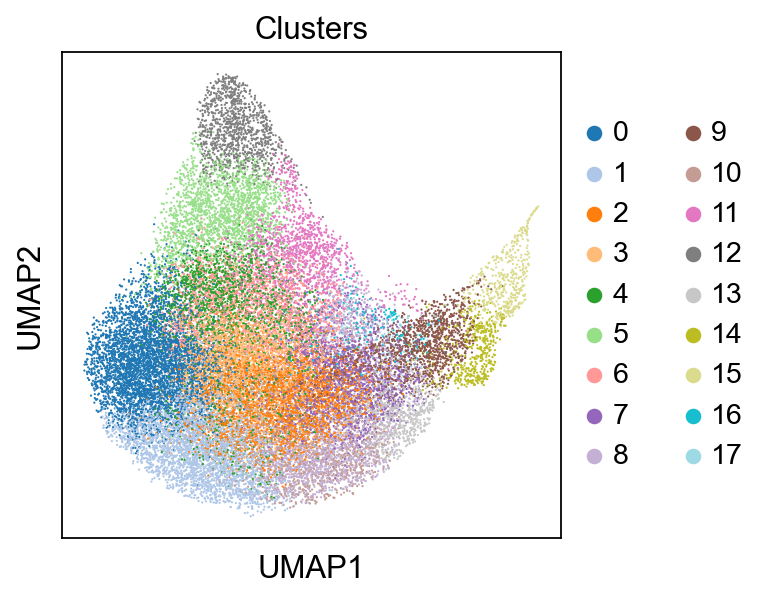

In [58]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


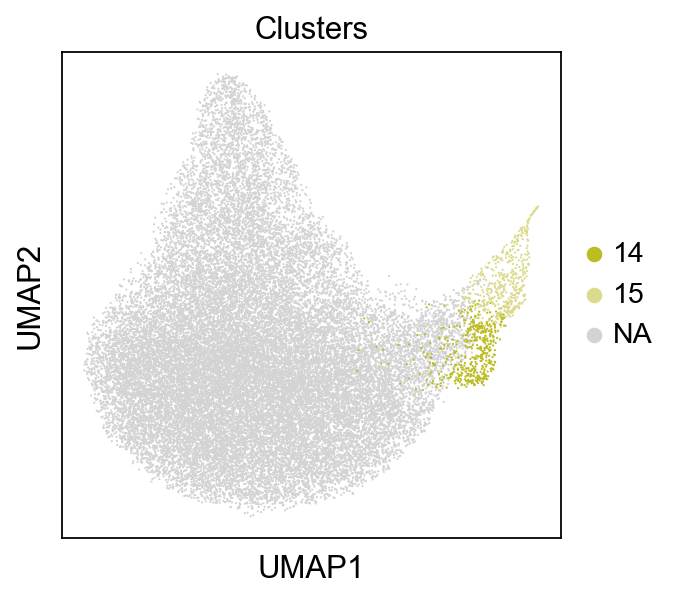

In [60]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[14,15]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


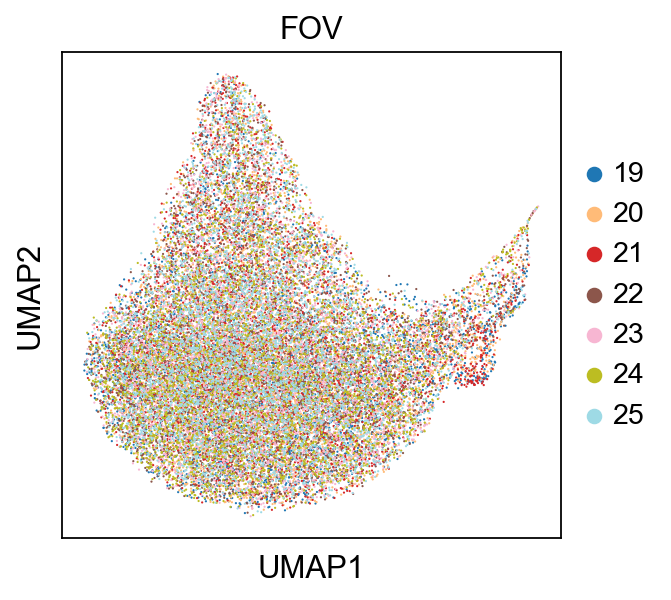

In [61]:
sc.pl.umap(
    adata, 
    color=['FOV'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["FOV"]
)

In [62]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv('TP' + tp + '/' + pt + tp + '_RGB_clusters.csv')

In [63]:
# save clustered data anndata object
adata_all.write_h5ad('TP' + tp + '/' + pt + tp + '_RGB_cell_features_clustered.h5ad')